In [1]:
import numpy as np
import pandas as pd
import shap
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to /Users/jasmineli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jasmineli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jasmineli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading in all the essentials for data manipulation
import numpy as np
#load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams
# We can use counter to count the objects
from collections import Counter
# This is our visual library
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

sales = pd.read_csv('summer-products-with-rating-and-performance_2020-08.csv')

In [3]:
def word_frequency(sentence):
  # joins all the sentenses
  sentence =" ".join(sentence)
  # creates tokens, creates lower class, removes numbers and lemmatizes the words
  new_tokens = word_tokenize(sentence)
  new_tokens = [t.lower() for t in new_tokens]
  new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
  new_tokens = [t for t in new_tokens if t.isalpha()]
  lemmatizer = WordNetLemmatizer()
  new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
  #counts the words, pairs and trigrams
  counted = Counter(new_tokens)
  counted_2= Counter(ngrams(new_tokens,2))
  counted_3= Counter(ngrams(new_tokens,3))
  #creates 3 data frames and returns thems
  word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
  trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
  return word_freq,word_pairs,trigrams,new_tokens

In [4]:
data2, data3, data4, tokens = word_frequency(sales['title_orig'].tolist())

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

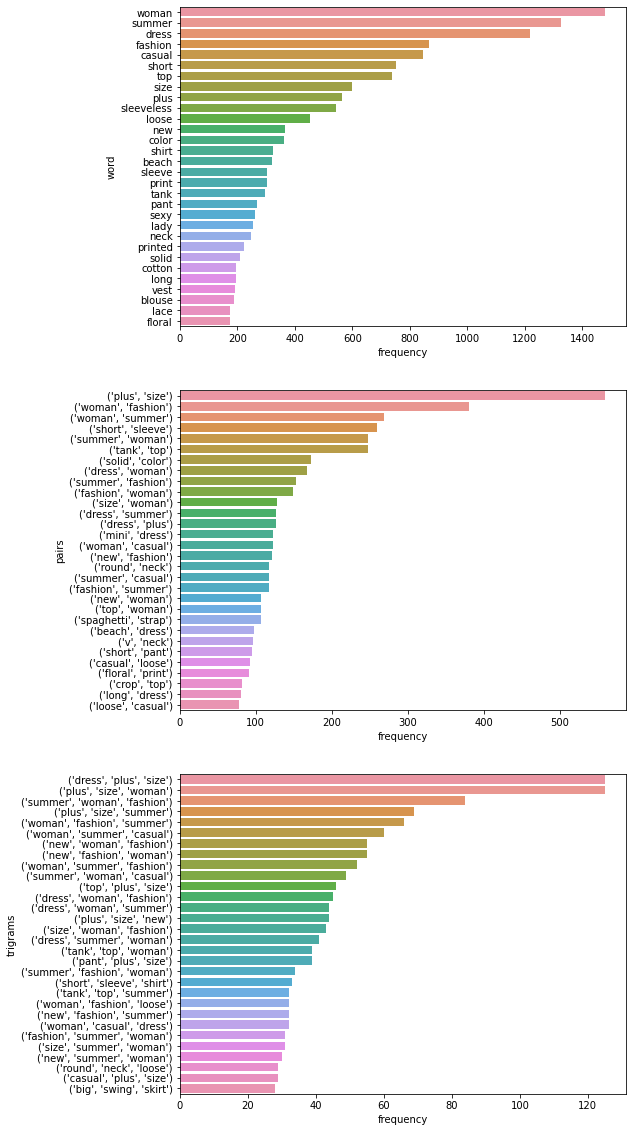

In [5]:
# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=data2.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=data3.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=data4.head(30))

In [6]:
def process_sentence(sentence):
  new_tokens = word_tokenize(sentence)
  new_tokens = [t.lower() for t in new_tokens]
  new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
  new_tokens = [t for t in new_tokens if t.isalpha()]
  lemmatizer = WordNetLemmatizer()
  new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
  return new_tokens

In [7]:
titles = sales['title_orig'].tolist()
data = [process_sentence(t) for t in titles]

In [8]:
model = gensim.models.Word2Vec(sentences=data, vector_size=100, window=5, min_count=1, workers=4)
model.train(data,total_examples=len(data),epochs=10)

(117381, 232280)

In [9]:
def caculate_average_word2vec(model, word_list):
  sum = np.matrix([model.wv[w] for w in word_list]).sum(axis=0)
  return sum / len(word_list)

In [15]:
word2vec_avg = [caculate_average_word2vec(model, d) for d in data]
print(word2vec_avg)
# sales['word2vec_avg'] = word2vec_avg
# X = sales.loc[:, sales.columns != 'units_sold']
# y = sales.units_sold
# print(X.dtypes)

[matrix([[ 0.03164693,  0.2569753 ,  0.01297896, -0.01836017, -0.01421785,
         -0.456803  ,  0.1832926 ,  0.5510371 , -0.44812843, -0.348029  ,
         -0.08749934, -0.49178517, -0.11018598,  0.17124687,  0.13125654,
         -0.31537288,  0.16318992, -0.3243384 , -0.02656748, -0.77157545,
          0.13523005,  0.09613402,  0.24873866, -0.08707345, -0.20447916,
          0.09584052, -0.37732327, -0.07290595, -0.20665674,  0.08278099,
          0.3314797 , -0.05247434,  0.23967263, -0.3632904 , -0.09697656,
          0.38382208, -0.05355672, -0.15921652, -0.07155702, -0.30481493,
          0.15191896, -0.3362672 , -0.1760606 ,  0.05569749,  0.1805935 ,
         -0.251708  , -0.17270562, -0.20287849,  0.13558213,  0.19987965,
         -0.03158305, -0.36110932, -0.04709296,  0.02009661,  0.18133156,
          0.05851637,  0.15914647, -0.09942523, -0.21407828,  0.15682095,
         -0.03970687, -0.10612865,  0.08860176,  0.16701931, -0.2893304 ,
          0.38467565,  0.04826218,  0

In [11]:
sales.drop_duplicates()
sales.nunique()
sales.drop(['title', 'title_orig', 'currency_buyer', 'has_urgency_banner', 'tags', 'product_url', 'product_picture', 
            'product_id', 'product_color', 'product_variation_size_id', 'shipping_option_name', 'urgency_text', 
            'origin_country', 'merchant_title', 'merchant_name', 'merchant_info_subtitle', 'merchant_id', 
            'merchant_rating', 'merchant_profile_picture', 'theme', 'crawl_month'], axis = 1, inplace = True)

TypeError: unhashable type: 'matrix'

In [ ]:
# sales.dropna().reset_index()
null_val = pd.DataFrame(sales.isnull().sum())
null_val.columns = ['null_val']
null_val['percent_'] = round(null_val['null_val'] / len(sales.index), 2) * 100
df = sales

In [ ]:
# sales.drop(['title', 'tags', 'product_color', 'product_variation_size_id', 'shipping_option_name', 'urgency_text', 'merchant_title', 'merchant_name', 'merchant_info_subtitle','origin_country', 'merchant_profile_picture', 'merchant_id', 'theme', 'crawl_month'], axis = 1, inplace = True)
X = sales.loc[:, sales.columns != 'units_sold']
y = sales.units_sold
print(X.dtypes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [ ]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)

In [ ]:
xgb.feature_importances_

In [ ]:
plt.barh(sales.columns, xgb.feature_importances_)